In [1]:
from DNAFlex.psf import GaussianPSF, negloglike
from scipy.special import erf
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt

I0=4000.0


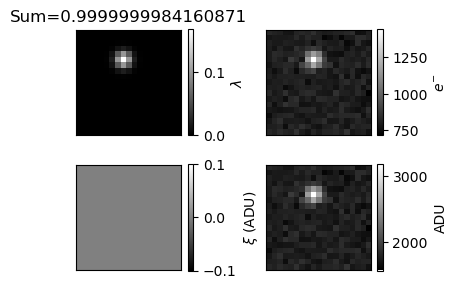

In [2]:
L = 19
omat = np.ones((L,L))
gain0 = 2.2
rmu0 = 0
rvar0 = 0
gain = gain0*omat #ADU/e-
rmu = rmu0*omat #ADU
rvar = rvar0*omat #ADU^2
pixel_size = 108.3 #nm
sigma = 0.22*640/1.4 #zhang 2007
sigma = sigma = sigma/pixel_size
N0 = 5000 #cps
B0 = 1000 #cps
texp = 1.0 #seconds
eta = 0.8 #quantum efficiency
I0 = eta*N0*texp #expected number of photons during exposure time (assume lam0 is determined for now)
B = eta*B0*texp
x0,y0 = (8.0,5.0)

print(f'I0={I0}')
psf = GaussianPSF(x0,y0,L,I0,B,sigma,gain,rmu,rvar)
adu = psf.generate(plot=True)

In [92]:
counts = np.round(adu/gain).astype(int)

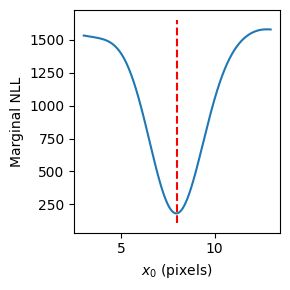

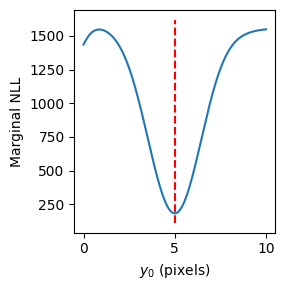

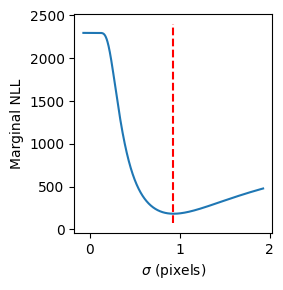

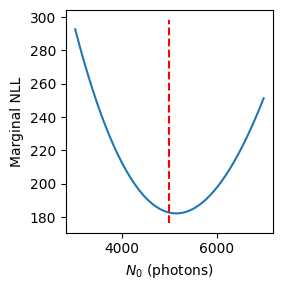

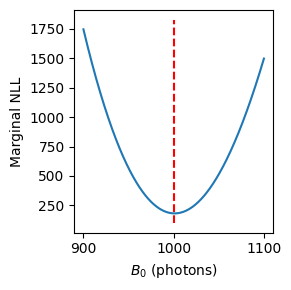

In [93]:
#Validate likelihood function with marginal log-likelihoods

x0space = np.linspace(x0-5,x0+5,1000)
y0space = np.linspace(y0-5,y0+5,1000)
sigspace = np.linspace(sigma-1,sigma+1,1000)
N0space = np.linspace(N0-2000,N0+2000,1000)
B0space = np.linspace(B0-100,B0+100,1000)

likex0 = np.zeros_like(x0space)
likey0 = np.zeros_like(y0space)
likesig = np.zeros_like(sigspace)
likeN = np.zeros_like(N0space)
likeB = np.zeros_like(B0space)

for n in range(1000):
    likex0[n] = negloglike(np.array([x0space[n],y0,sigma,N0,B0]),counts,eta,texp)
    likey0[n] = negloglike(np.array([x0,y0space[n],sigma,N0,B0]),counts,eta,texp)
    likesig[n] = negloglike(np.array([x0,y0,sigspace[n],N0,B0]),counts,eta,texp)
    likeN[n] = negloglike(np.array([x0,y0,sigma,N0space[n],B0]),counts,eta,texp)
    likeB[n] = negloglike(np.array([x0,y0,sigma,N0,B0space[n]]),counts,eta,texp)
    
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.plot(x0space,likex0)
ax.vlines(x0,*ax.get_ylim(),color='red',linestyle='--')
ax.set_xlabel(r'$x_{0}$ (pixels)')
ax.set_ylabel('Marginal NLL')
plt.tight_layout()
plt.show()
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.plot(y0space,likey0)
ax.vlines(y0,*ax.get_ylim(),color='red',linestyle='--')
ax.set_xlabel(r'$y_{0}$ (pixels)')
ax.set_ylabel('Marginal NLL')
plt.tight_layout()
plt.show()
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.plot(sigspace,likesig)
ax.vlines(sigma,*ax.get_ylim(),color='red',linestyle='--')
ax.set_xlabel(r'$\sigma$ (pixels)')
ax.set_ylabel('Marginal NLL')
plt.tight_layout()
plt.show()
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.plot(N0space,likeN)
ax.vlines(N0,*ax.get_ylim(),color='red',linestyle='--')
ax.set_xlabel(r'$N_{0}$ (photons)')
ax.set_ylabel('Marginal NLL')
plt.tight_layout()
plt.show()
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.plot(B0space,likeB)
ax.vlines(B0,*ax.get_ylim(),color='red',linestyle='--')
ax.set_xlabel(r'$B_{0}$ (photons)')
ax.set_ylabel('Marginal NLL')
plt.tight_layout()
plt.show()

In [94]:
#Maximum Likelihood Estimation

theta0 = np.array([x0,y0,sigma,N0,B0]) #initial guess
mu_err = np.zeros_like(theta0)
cov_err = np.diag(np.array([2.0,2.0,0.15,5000.0,5000.0]))
err = multivariate_normal(mu_err,cov_err)
theta = theta0 + err.rvs()
print(f'Initial theta: {theta}')
bounds = [(0, L), (0, L), (0, 5.0), (0, None), (0, None)]
result = minimize(negloglike, theta0, args=(counts,eta,texp),bounds=bounds)

# Retrieve the optimal parameter values from the output
theta_mle = result.x

print("Maximum likelihood estimate for theta:", theta_mle)

Initial theta: [   8.143445      8.06853422    0.64806806 5019.68404041  997.44675293]
Maximum likelihood estimate for theta: [   7.95191694    5.00112685    0.93132598 5000.02518398 1001.00239043]
